In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import cartopy.crs as ccrs
from cartopy.io.img_tiles import *

from scipy.ndimage.filters import gaussian_filter

%matplotlib inline

from pointprocess import *
import pointprocess.plotting as pplot
from lightning_setup import *

from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())
SR_LOC = os.environ.get('SR_LOC')

I struggled for a WHILE to find a basemap tiling service that I was happy with. There are some good options available through Mapbox, but the best plain, no label, shaded relief that I found is provided by ESRI. Check out their license before you use this tiler.

In [2]:
MAPBOX_TOKEN = os.environ['MAPBOX_TOKEN']

class ShadedReliefESRI(GoogleTiles):
    # shaded relief
    def _image_url(self, tile):
        x, y, z = tile
        url = ('https://server.arcgisonline.com/ArcGIS/rest/services/' \
               'World_Shaded_Relief/MapServer/tile/{z}/{y}/{x}').format(
               z=z, y=y, x=x)
        return url

In [3]:
def map_contour(grid, ax=None, extents=None,
                tiler=StamenTerrain(), zoom=6,
                vmin=-1, vmax=2, N=7, fontsize=10):
    if ax is None:
        plt.figure(figsize=(10,8))
        ax = plt.axes(projection=ccrs.PlateCarree())
    if extents is not None:
        xmin, xmax, ymin, ymax = extents
        x = c.gridx[xmin:xmax]
        y = c.gridy[ymin:ymax]
        z = grid[ymin:ymax, xmin:xmax]
    elif c.gridx.shape[0] != grid.shape[1]:
        x = (c.gridx[:-1]+c.gridx[1:])/2.
        y = (c.gridy[:-1]+c.gridy[1:])/2.
        z = grid
    else:
        x = c.gridx
        y = c.gridy
        x = grid
    CS = plt.contour(x, y, z, N, cmap='Greys', vmin=vmin, vmax=vmax)
    plt.clabel(CS, inline=1, fontsize=10)
    ax.add_image(tiler, zoom)
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False
    plt.title("Mean JA Flash Density for Cedar City")

In [4]:
c = Region(city=cities['cedar'])
c.define_grid()

### JA Flash Density for CG 2010-2015

In [5]:
%%time
MMDC_grid = {}
MMFC_grid = {}
for m in [7,8]:
    ds = c.get_ds(y='201*', m=m, filter_CG=True, cols=['strokes', 'amplitude', 'cloud_ground'])
    print(m)
    ds.close()
    MMFC_grid.update({m: c.FC_grid})

7
8
CPU times: user 24.9 s, sys: 685 ms, total: 25.5 s
Wall time: 25 s


In [15]:
JAFC = MMFC_grid[7] + MMFC_grid[8]
mean_JAFD = JAFC/float(6)

In [293]:
centery = (c.gridy[:-1]+c.gridy[1:])/2.
centerx = (c.gridx[:-1]+c.gridx[1:])/2.

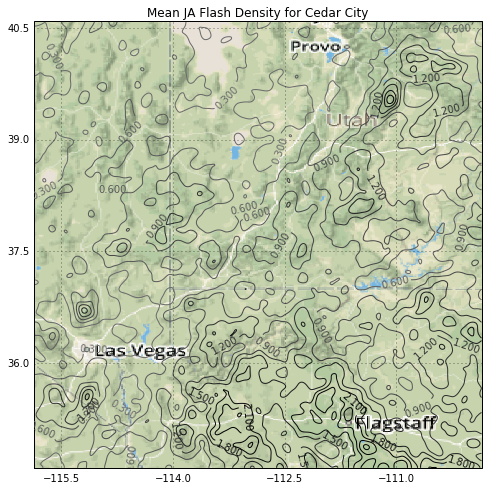

In [17]:
smoothed = gaussian_filter(mean_JAFD, 5)
map_contour(smoothed, zoom=6, vmin=-3, vmax=2, N=10, fontsize=10,
            tiler=MapboxTiles(MAPBOX_TOKEN, 'mapbox.streets'));

In [20]:
xmin, xmax = np.searchsorted(c.gridx, np.array([-112.4, -111.2]))
ymin, ymax = np.searchsorted(c.gridy, np.array([37.1, 38.3]))

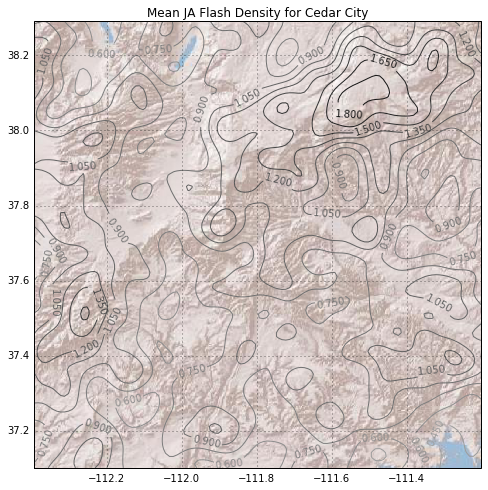

In [21]:
smoothed = gaussian_filter(mean_JAFD, 3)
map_contour(smoothed, extents=[xmin, xmax, ymin, ymax], zoom=9, N=10,
            tiler=ShadedReliefESRI());

In [9]:
%%time
JFC_grid = {}
AFC_grid = {}
for y in range(1996, 2016):
    ds = c.get_ds(m=7, y=y, filter_CG=-10)
    ds.close()
    JFC_grid.update({y: c.FC_grid})
    ds = c.get_ds(m=8, y=y, filter_CG=-10)
    ds.close()
    AFC_grid.update({y: c.FC_grid})

CPU times: user 55.3 s, sys: 701 ms, total: 56 s
Wall time: 55.2 s


In [20]:
JAFC = np.sum(list(JFC_grid.values()), axis=0) + np.sum(list(AFC_grid.values()), axis=0)
mean_JAFD = JAFC/float(len(JFC_grid.keys()))

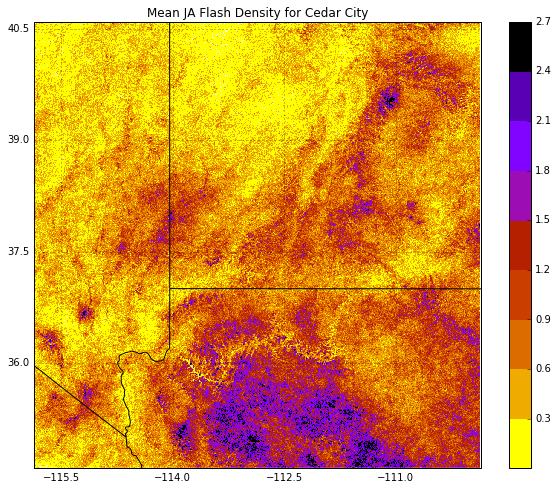

In [268]:
plt.figure(figsize=(10,8))
c.plot_grid(JAFC/20., cmap=cmap, vmin=.001, vmax=2.7, zorder=-1, cbar=True);
plt.title("Mean JA Flash Density for Cedar City");

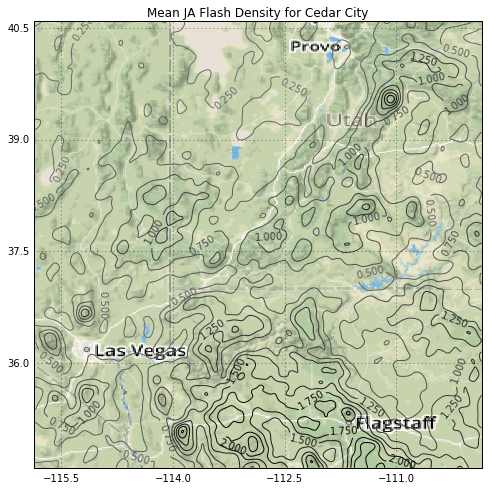

In [21]:
smoothed = gaussian_filter(mean_JAFD, 5)
map_contour(smoothed, zoom=6, vmin=-3, vmax=2, N=10, fontsize=10,
            tiler=MapboxTiles(MAPBOX_TOKEN, 'mapbox.streets'))

In [22]:
xmin, xmax = np.searchsorted(c.gridx, np.array([-112.4, -111.2]))
ymin, ymax = np.searchsorted(c.gridy, np.array([37.1, 38.3]))

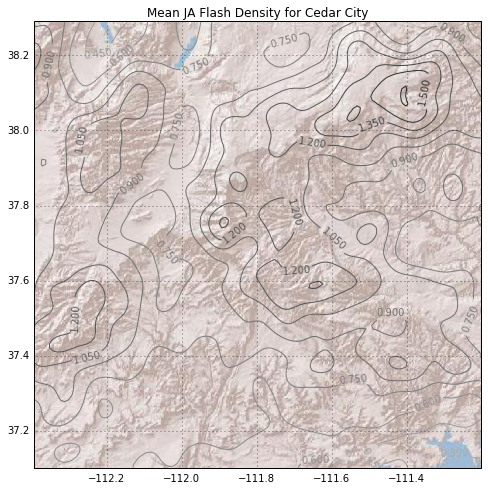

In [23]:
smoothed = gaussian_filter(mean_JAFD, 3)
map_contour(smoothed, extents=[xmin, xmax, ymin, ymax], zoom=9, N=10,
            tiler=ShadedReliefESRI())

## peak time
[Top](#Regional-Climatology) | [Region](#object-orientation) | [flash density](#flash-density) | [diurnal cycle](#diurnal-cycle) | [Largest 100](#top-100) | [peak](#peak-time) | [amplitude diurnal cycle](#amplitude-of-DC) | [CG amplitude](#CG-amplitude)

JJA CG flash density (Hour time resolution); ~ 10 km grid


In [31]:
%%time
JDC_grid = {}
ADC_grid = {}
for y in range(1996, 2016):
    ds = c.get_ds(m=7, y=y, filter_CG=-10)
    c.to_DC_grid(ds)
    ds.close()
    JDC_grid.update({y: c.DC_grid})
    ds = c.get_ds(m=8, y=y, filter_CG=-10)
    c.to_DC_grid(ds)
    ds.close()
    ADC_grid.update({y: c.DC_grid})

CPU times: user 1min 28s, sys: 1.3 s, total: 1min 29s
Wall time: 1min 28s


In [225]:
hourly3D = {}
for y in range(1996, 2016):
    hourly3D.update({y: np.stack(JDC_grid[y].values())+ np.stack(ADC_grid[y].values())})

In [229]:
h3D = hourly3D[1996]
for y in range(1996, 2016):
    h3D+=hourly3D[y]

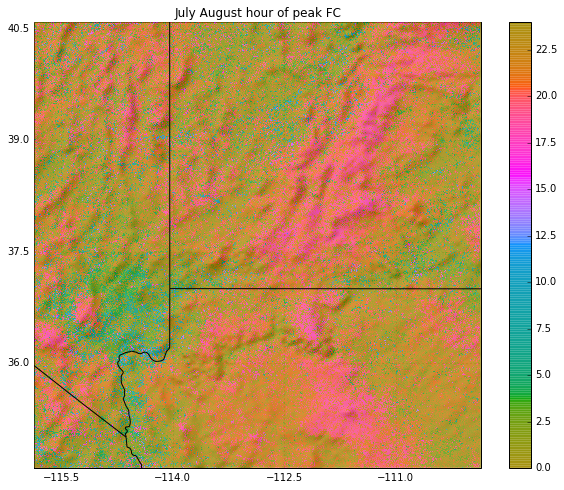

In [234]:
plt.figure(figsize=(10,8))

cmap_husl = mpl.colors.ListedColormap(sns.husl_palette(256, .2, l=.6, s=1))
peak_time = np.argmax(h3D, axis=0)

im, ax = c.plot_grid(peak_time, cmap=cmap_husl, vmin=0, vmax=24, cbar=True, alpha=.8, zorder=5)
pplot.pre_shaded(ax, fname='/home/jsignell/data/SR_50M/SR_50M.tif')
ax.set_extent([c.gridx.min(), c.gridx.max(), c.gridy.min(), c.gridy.max()])
ax.set_title('July August hour of peak FC');

## amplitude of DC
[Top](#Regional-Climatology) | [Region](#object-orientation) | [flash density](#flash-density) | [diurnal cycle](#diurnal-cycle) | [Largest 100](#top-100) | [peak](#peak-time) | [amplitude diurnal cycle](#amplitude-of-DC) | [CG amplitude](#CG-amplitude)

 - “Amplitude” of the diurnal cycle; 1 hour time resolution ~1km grid.  CG flash density at the time of maximum flash density - CG flash density a time of minimum flash density divided by the mean flash density. 

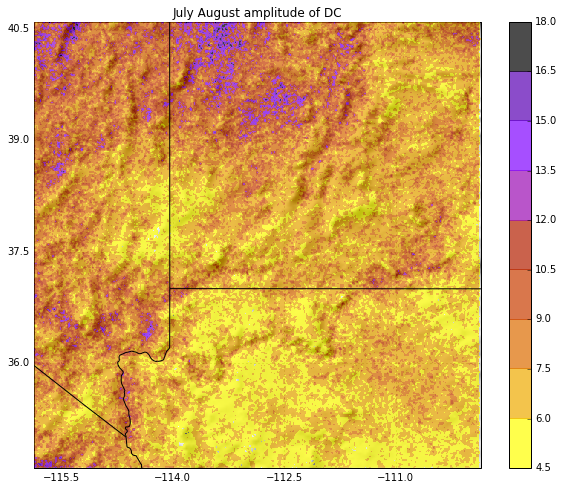

In [287]:
plt.figure(figsize=(10, 8))

amplitude = ((np.max(h3D, axis=0)-np.min(h3D, axis=0))/np.mean(h3D, axis=0))
amplitude = np.nan_to_num(amplitude)
smoothed = gaussian_filter(amplitude, 1)
im, ax = c.plot_grid(smoothed, cmap=cmap, vmin=4.5, vmax=18, cbar=True, zorder=5, alpha=.7)
pplot.pre_shaded(ax, fname='/home/jsignell/data/SR_50M/SR_50M.tif')
ax.set_extent([c.gridx.min(), c.gridx.max(), c.gridy.min(), c.gridy.max()])
ax.set_title('July August amplitude of DC');